In [1]:
#%% IMPORTS OF PACKAGES

import mne
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import glob
plt.ion() #toggle interactive plotting
# import numpy as np

In [2]:
data_path = "/work/MEG_data"
ID = "0147"
date_stamp = "20240926_000000"
sess = "A"

log_path = join(data_path, 'logfiles')

meg_path = join(data_path, ID, date_stamp, "MEG/001.sessA/files")
subjects_dir = "/work/freesurfer/"
raw_name = "sess" + sess + ".fif"

In [3]:
#%% READ RAW AND PLOT

raw = mne.io.read_raw_fif(join(meg_path, raw_name), preload=True)
#raw.plot() ## what happens after 10 seconds?
#raw.compute_psd(n_jobs=-1).plot()
#raw.compute_psd(n_jobs=-1, tmax=9).plot()

Opening raw data file /work/MEG_data/0147/20240926_000000/MEG/001.sessA/files/sessA.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 1090000 ... 1784999 =   1090.000 ...  1784.999 secs
Ready.
Reading 0 ... 694999  =      0.000 ...   694.999 secs...


/tmp/ipykernel_1316/1593384855.py:3: RuntimeWarning: This filename (/work/MEG_data/0147/20240926_000000/MEG/001.sessA/files/sessA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(join(meg_path, raw_name), preload=True)


In [4]:
raw.filter(l_freq=None, h_freq=40, n_jobs=-1) # alters raw in-place
#raw.compute_psd(n_jobs=-1).plot()
#raw.plot()

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    8.4s finished


<Raw | sessA.fif, 323 x 695000 (695.0 s), ~1.68 GB, data loaded>

In [5]:
#%% FIND EVENTS

# events = mne.find_events(raw)#, min_duration=0.002) ## returns a numpy array
events = mne.find_events(raw, min_duration=0.002,consecutive=True) ## returns a numpy array

#mne.viz.plot_events(events, sfreq=raw.info['sfreq']) ## 
trigger_vals = [1,2,3,4,110,120,130,140,210,211,220,221,230,231,240,241]
true_events = events[np.isin(events[:,2], trigger_vals),:]

event_id = {
            'Visual/Loss/One': 211, # Win screen, deck 1
            'Visual/Loss/Two': 221, # Win screen, deck 2
            'Visual/Loss/Three': 231, # Win screen, deck 3
            'Visual/Loss/Four': 241, # Win screen, deck 4
              }  

repeat_idx = np.where(np.diff(true_events[:,2])==0)[0]
repeat_idx2 = repeat_idx+1 # we need the index of both the first and the second value in those pairs (it's only the second of the two that we delete)
repeat_combined = [[i, j] for i, j in zip(repeat_idx, repeat_idx2)] # we group indices in pairs for printing

# print to inspect if needed
#print(cropped_events[repeat_combined, 2])
#print(cropped_events[repeat_combined, :])

cropped_events = np.delete(true_events, repeat_idx2, axis=0)

# loading in the logfiles

log_files = glob.glob(join(log_path, str(int(ID)) + sess + '*'))

df_load = []
for lf in np.sort(log_files):
    print(lf)
    df_load.append(pd.read_csv(join(log_path, lf)))
                        
df = pd.concat(df_load)

# cleaning the concatenated logfiles a bit

df_cropped = df.drop(['ID', 'dur_measured_decks', 'offset_decks', 'exp_type', 'offset_win'], axis=1) # throwing out columns with all NaN
df_cropped['deck_marked'] = df_cropped['init_mark'] + 1 # adjusting the indexing of "init_mark" to reflect actual deck-number rather than python index

# Any mismatches?
df_cropped[['deck_marked']].T.to_numpy()[0]-cropped_events[cropped_events[:,2]<10,2]

# If you inspect these, you'll see that there was a button press trigger sent before each of these 13 triggers, 
# which for some reason messed up the reading of the trigger (to be 1 higher than it really was)
# So let's replace the deck-trigger-labels with the ones from the logfile
deck_events_idx = np.where(cropped_events[:,2]<10)[0] # what are the indices of these deck events in the cropped_events array?
#print(deck_events_idx)
cropped_events[deck_events_idx, 2] = df_cropped['deck_marked']

# fixing the deck selection labels that might be missing
#print(df_cropped[['deck_select']].T.to_numpy()[0])
deck_select = (cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]/10 - 10)
deck_select_idx = np.where((cropped_events[:,2]>100) & (cropped_events[:,2]<150))[0]
#print(deck_select.astype('int'))

temp_deck_events = np.pad(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]/10 - 10,
                          (0,160-len(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]/10 - 10)), 'constant')

#print(df_cropped[['deck_select']].T.to_numpy()[0] - temp_deck_events.astype('int'))
#print(df_cropped[['deck_select']].T.to_numpy()[0] - deck_select[:160].astype('int'))

#print(deck_select_idx)

2010 events found on stim channel STI101
Event IDs: [  1   2   3   4  11  12  13  14  15  16 110 120 126 130 134 140 156 210
 211 220 221 230 231 238 239 240 241 243 246 247 252 254 255]
/work/MEG_data/logfiles/147A_sess_1 (2024-09-26 10-57-59).csv
/work/MEG_data/logfiles/147A_sess_2 (2024-09-26 11-01-09).csv
/work/MEG_data/logfiles/147A_sess_3 (2024-09-26 11-03-55).csv
/work/MEG_data/logfiles/147A_sess_4 (2024-09-26 11-06-38).csv


In [6]:
# longer epoching for proper ERF analysis
#reject = dict(mag=4e-12, grad=4000e-13, eog=250e-6) # T, T/m, V
reject = None
#Create the epochs
epochs = mne.Epochs(
    raw,
    cropped_events,
    event_id,
    on_missing='warn',   #only report on missing events in data, but continue script
    tmin=-0.200,
    tmax=1.000,
    baseline=(None, 0),
    reject=reject,
    preload=True,
    proj=False,
)  ## have proj True, if you wanna reject


Not setting metadata
69 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 69 events and 1201 original time points ...
0 bad epochs dropped


In [7]:
epochs.pick_types(meg=True, eog=False, ias=False, emg=False, misc=False,
                  stim=False, syst=False)

#epochs.plot()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Epochs | 69 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~198.6 MB, data loaded,
 'Visual/Loss/One': 8
 'Visual/Loss/Two': 2
 'Visual/Loss/Three': 58
 'Visual/Loss/Four': 1>

In [9]:
# %% EVOKED - AVERAGE - projs not applied

#epochs.set_annotations(annotations, on_missing == "warn")

evokeds = list()
for event in event_id:
    

    evoked = epochs[event].average()
    evokeds.append(evoked)
  # evoked.plot(window_title=evoked.comment)

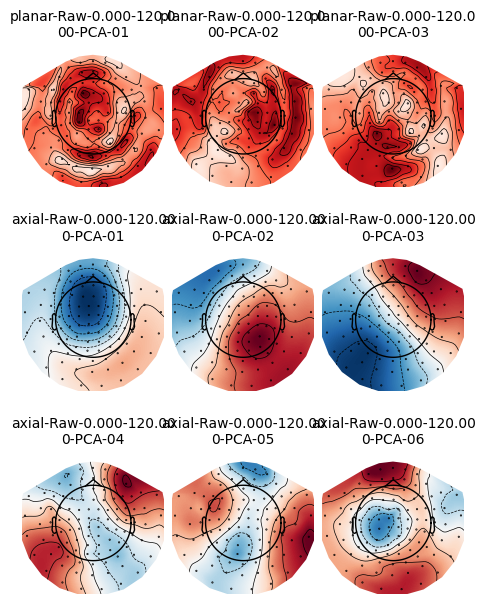

Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...


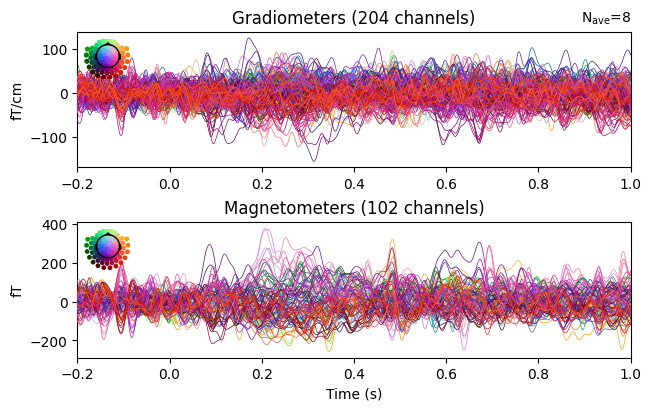

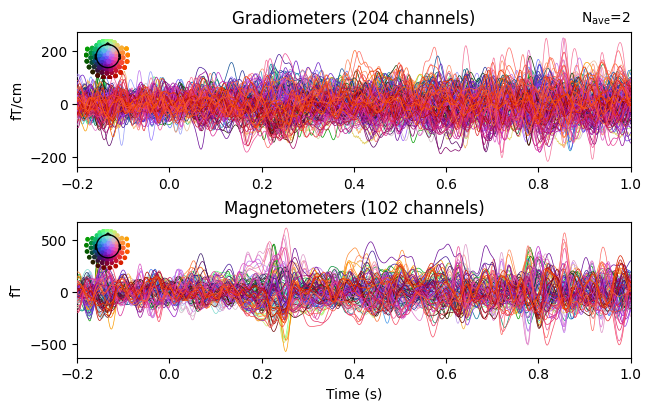

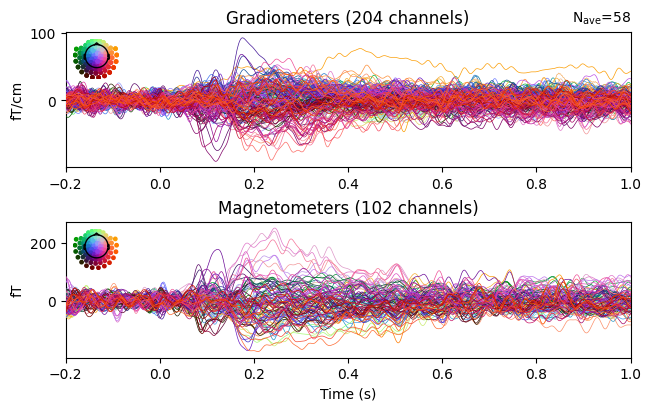

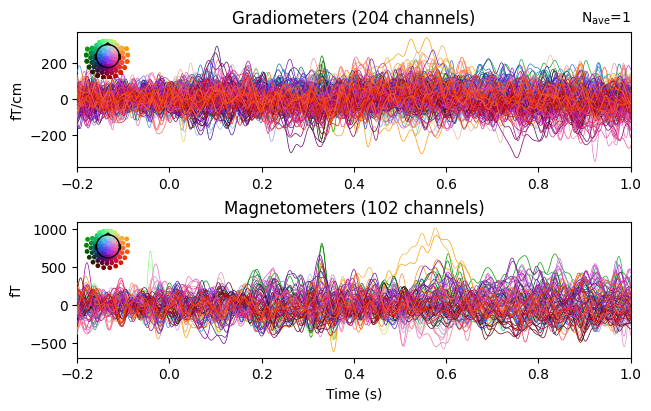

In [10]:
# %% PROJS
mne.viz.plot_projs_topomap(evoked.info["projs"], evoked.info)

epochs.apply_proj()

evokeds = list()
for event in event_id:

    evoked = epochs[event].average()
    evokeds.append(evoked)
    evoked.plot(window_title=evoked.comment)

In [11]:
# %% SOURCE RECONSTRUCTION 

bem_path = "/work/freesurfer/" + "0147/bem"    
subjects_dir = "/work/freesurfer/"    #path to all subjects
fwd_name = "0147-sessA-src-fwd.fif"  
subject = '0147'

# read forward solution
fwd = mne.read_forward_solution(join(bem_path, fwd_name))
src = fwd["src"]  # where are the sources
trans = fwd["mri_head_t"]  # what's the transformation between mri and head space
info = epochs.info  # where are the sensors?
bem_sol = fwd["sol"]  # how do electric fields spread from the sources inside the head?

Reading forward solution from /work/freesurfer/0147/bem/0147-sessA-src-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 13869
[done]
Computing rank from covariance with rank=None
    Using tolerance 8.2e-15 (2.2e-16 eps * 102 dim * 0.36  max singular value)
    Estimated rank (mag): 96
    MAG: rank 96 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.9e-13 (2.2e-16 eps * 204 dim * 4.1  max singular value)
    Estimated rank (grad): 201
    GRAD: rank 201 computed from 204 data channels with 0 projectors


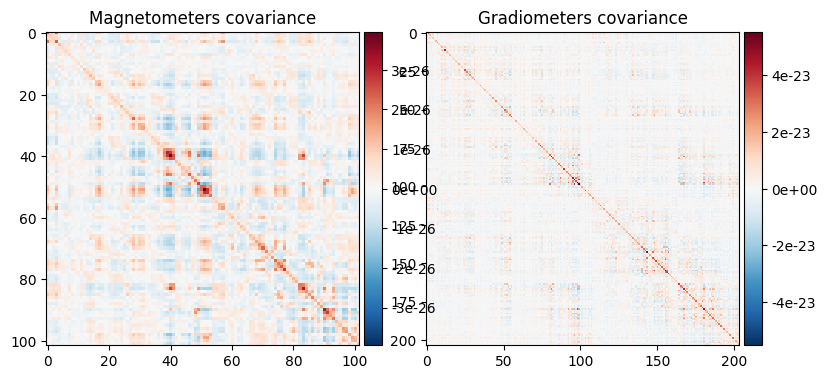

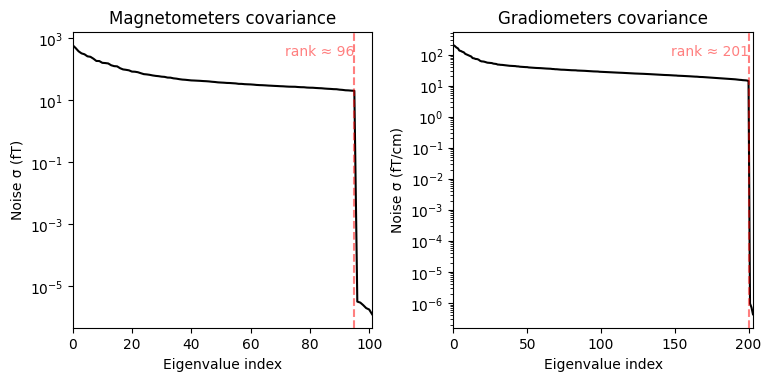

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [12]:
# %% estimate covariance in the baseline to whiten magnetometers and gradiometers, 
# i.e. normalizing magnetometers, gradiometers and electrode readings to make them comparable
noise_cov = mne.compute_covariance(epochs, tmax=0.000)
noise_cov.plot(epochs.info)  # not full range due to projectors projected out

In [13]:
# %% operator that specifies how noise cov should be applied to the fwd
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7826/8196 = 10.020451
    scale = 3.35804e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 2.9e-13 (2.2e-16 eps * 306 dim * 4.3  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and 

In [14]:
# %% estimate source time courses for evoked responses
stc = mne.minimum_norm.apply_inverse(evoked, inverse_operator, method="MNE")
print(stc.data.shape)
print(src)
# stc.plot(subjects_dir=subjects_dir, hemi='both', initial_time=0.170)

#%% NOTE: If you don't want to use the averaged evoked response, but want to keep all the epochs without averaging for a later classification, then you need to apply 'apply_inverse_epochs()' instead.
#Look at the buttom of this notebook, there is some code for that.

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
Applying inverse operator to "Visual/Loss/Four"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  44.4% variance
    Combining the current components...
[done]
(8196, 1201)
<SourceSpaces: [<surface (lh), n_vertices=129340, n_used=4098>, <surface (rh), n_vertices=128149, n_used=4098>] head coords, subject '0147', ~25.8 MB>


In [17]:
labels_vol = [
    #amygdala
    "Amygdala",
    #insula
    "Left-Insula",
    "Right-Insula",
    #anterior cingulate cortex
    "ctx-lh-caudalanteriorcingulate",
    "ctx-lh-rostralanteriorcingulate",
    "ctx-rh-caudalanteriorcingulate",
    "ctx-rh-rostralanteriorcingulate",
    #prefrontal cortex
    "ctx-lh-prefrontal",
    "ctx-rh-prefrontal",
    #striatum???
    "Left-Basal-Ganglia",
    "Right-Basal-Ganglia",
    #brainstem for ref?
    'Brain-Stem'
]

mri_path = "/work/freesurfer/" + "0147/mri"
fname_aseg = mri_path + "/aseg.mgz"


vol_src = mne.setup_volume_source_space(
    subject=subject,
    mri=fname_aseg,
    pos=10.0,
    bem=bem_path + '/0147-bem-sol.fif',
    volume_label=labels_vol,
    subjects_dir=subjects_dir,
    add_interpolator=True,  # just for speed, usually this should be True
    verbose=True,
)

# Generate the mixed source space
src += vol_src
print(
    f"The source space contains {len(src)} spaces and "
    f"{sum(s['nuse'] for s in src)} vertices"
)

BEM              : /work/freesurfer/0147/bem/0147-bem-sol.fif
grid                  : 10.0 mm
mindist               : 5.0 mm
MRI volume            : /work/freesurfer/0147/mri/aseg.mgz

Reading /work/freesurfer/0147/mri/aseg.mgz...

Loaded inner skull from /work/freesurfer/0147/bem/0147-bem-sol.fif (2562 nodes)
Surface CM = (   1.6  -19.7   34.4) mm
Surface fits inside a sphere with radius  100.7 mm
Surface extent:
    x =  -67.3 ...   72.1 mm
    y = -105.6 ...   80.3 mm
    z =  -42.4 ...  100.4 mm
Grid extent:
    x =  -70.0 ...   80.0 mm
    y = -110.0 ...   90.0 mm
    z =  -50.0 ...  110.0 mm
5712 sources before omitting any.
3850 sources after omitting infeasible sources not within 0.0 - 100.7 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 3850 points...
    Found  595/3850 points inside  an interior sphere of radius   52.2 mm
    Found    0/3850 point

/tmp/ipykernel_1316/2546526282.py:26: RuntimeWarning: Found no usable vertices in volume label 'Amygdala' (id=218) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykernel_1316/2546526282.py:26: RuntimeWarning: Found no usable vertices in volume label 'Left-Insula' (id=19) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykernel_1316/2546526282.py:26: RuntimeWarning: Found no usable vertices in volume label 'Right-Insula' (id=55) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykernel_1316/2546526282.py:26: RuntimeWarning: Found no usable vertices in volume label 'ctx-lh-caudalanteriorcingulate' (id=1002) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykernel_1316/2546526282.py:26: RuntimeWarning: Found no usable vertices in volume label 'ctx-lh-rostralanteriorcingulate' (id=1026) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykernel_1316/2546526282.py:26: RuntimeWarning:

    0/16777216 nonzero values for Amygdala
    0/16777216 nonzero values for Left-Insula
    0/16777216 nonzero values for Right-Insula
    0/16777216 nonzero values for ctx-lh-caudalanteriorcingulate
    0/16777216 nonzero values for ctx-lh-rostralanteriorcingulate
    0/16777216 nonzero values for ctx-rh-caudalanteriorcingulate
    0/16777216 nonzero values for ctx-rh-rostralanteriorcingulate
    0/16777216 nonzero values for ctx-lh-prefrontal
    0/16777216 nonzero values for ctx-rh-prefrontal
    0/16777216 nonzero values for Left-Basal-Ganglia
    0/16777216 nonzero values for Right-Basal-Ganglia
    465252/16777216 nonzero values for Brain-Stem
[done]
The source space contains 25 spaces and 8220 vertices


In [18]:
## forward model as a volume
fname = join(meg_path, raw_name)
path_trans = join(bem_path, '0147-trans.fif')
output_name = bem_path + '\0147-sessA-src-fwd_vol.fif'

info = mne.io.read_info(fname)
trans = path_trans   
bem = join(bem_path, '0147-bem-sol.fif')            

fwd_vol = mne.make_forward_solution(info, trans, vol_src, bem)

    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
Source space          : <SourceSpaces: [<volume (Amygdala), n_used=0>, <volume (Left-Insula), n_used=0>, <volume (Right-Insula), n_used=0>, <volume (ctx-lh-caudalanteriorcingulate), n_used=0>, <volume (ctx-lh-rostralanteriorcingulate), n_used=0>, <volume (ctx-rh-caudalanteriorcingulate), n_used=0>, <volume (ctx-rh-rostralanteriorcingulate), n_used=0>, <volume (ctx-lh-prefrontal), n_used=0>, <volume (ctx-rh-prefrontal), n_used=0>, <volume (Left-Basal-Ganglia)

In [19]:
#inverse model
inverse_operator_vol = mne.minimum_norm.make_inverse_operator(info, fwd_vol, noise_cov)

Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 25/24 = 4.135115
    scale = 1.12617e-08 exp = 0.8
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 2.9e-13 (2.2e-16 eps * 306 dim * 4.3  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 11.3781
    scaling factor to adjust the trace = 1.26311e+16 (nchan = 306 nzero = 9)


In [20]:
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

#inverse_operator = read_inverse_operator(fname_inv)
src_vol = inverse_operator_vol['src']

# Compute inverse solution
stc_vol = mne.minimum_norm.apply_inverse(evoked, inverse_operator_vol, lambda2, method)
#stc.crop(0.0, 0.2)


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "Visual/Loss/Four"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  12.8% variance
    Combining the current components...
    dSPM...
[done]


In [21]:
#timestamps between 0 and 1
zero_to_half = stc_vol.times[200:1200]
z_t_h_50 = zero_to_half[0::50]
#find og index
stc_vol_list = list(stc_vol.times)
og_indices_list = []
for j in z_t_h_50:
    if stc_vol_list.index(j):
        og_indices_list.append(stc_vol_list.index(j))

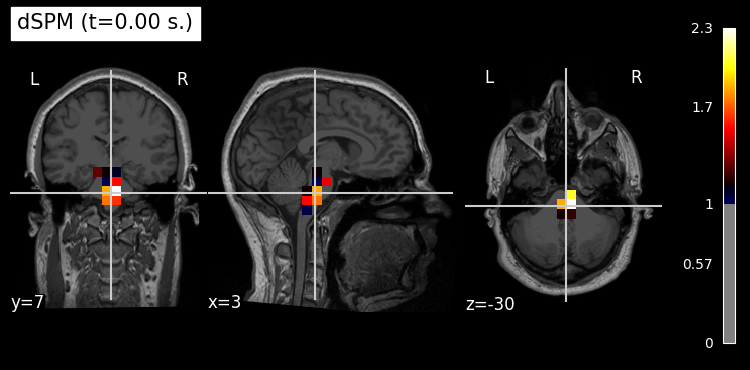

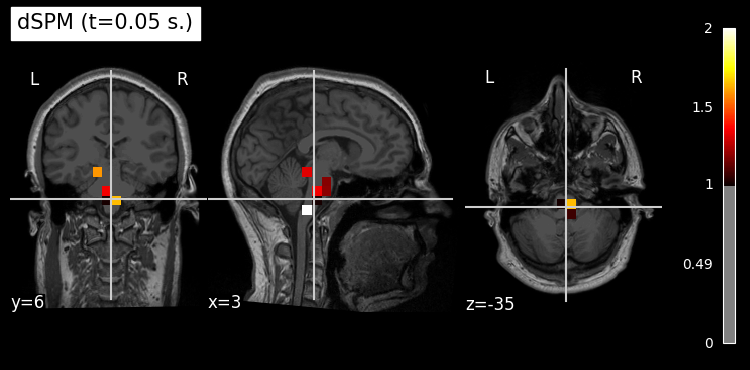

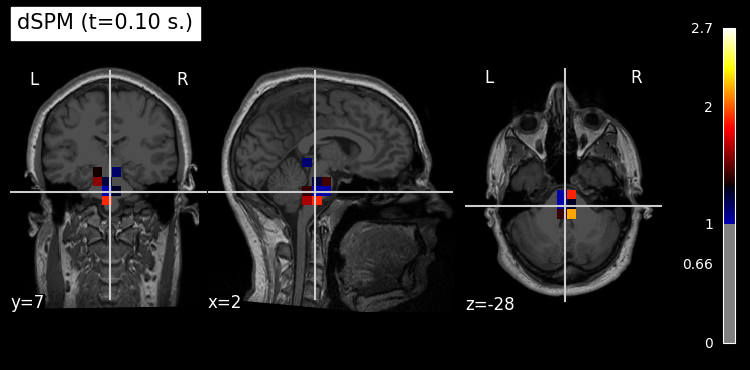

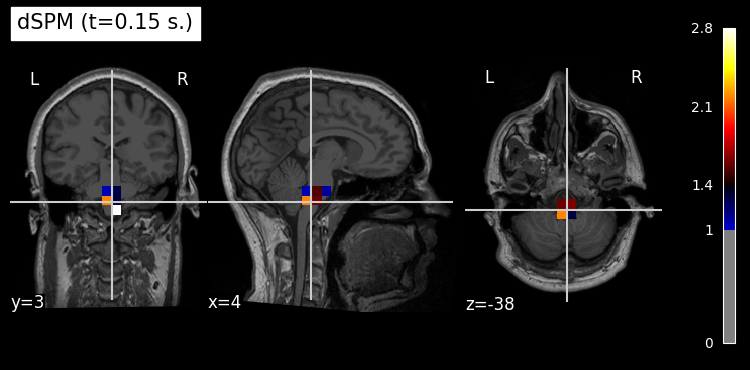

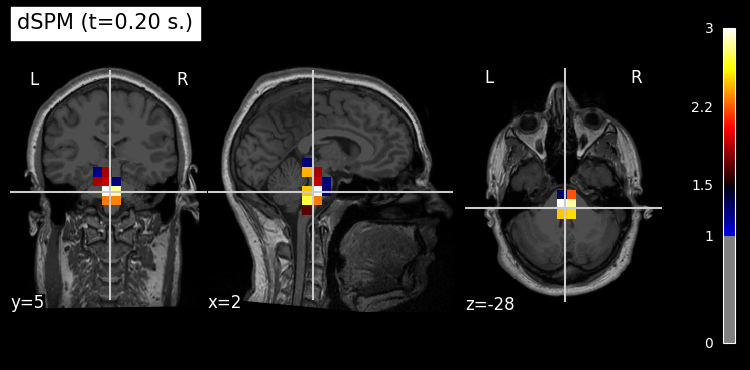

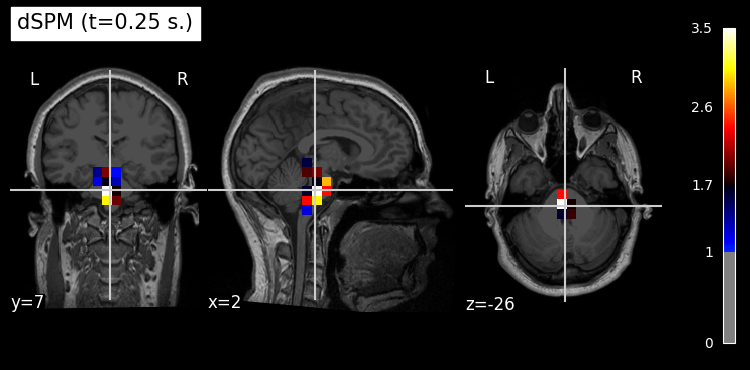

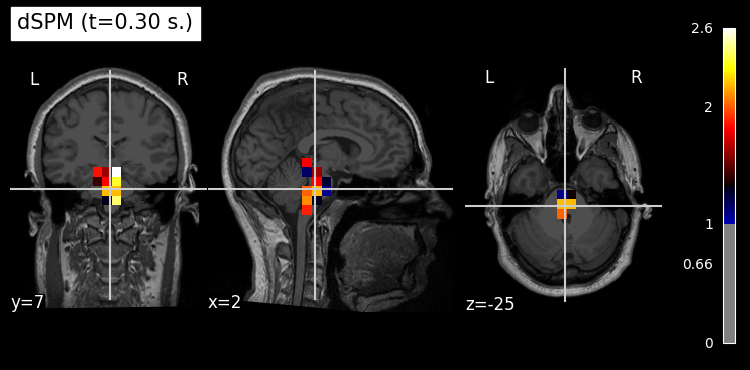

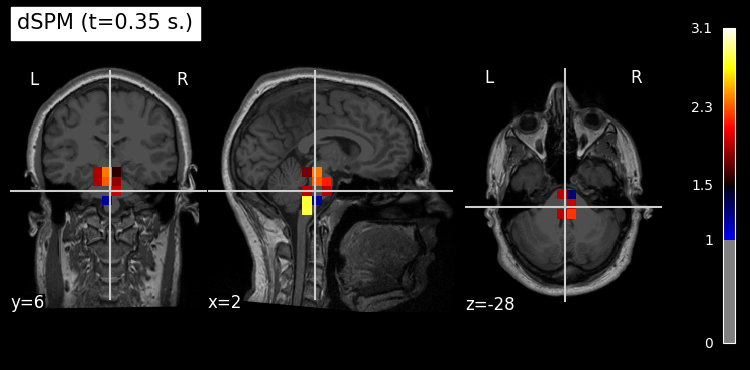

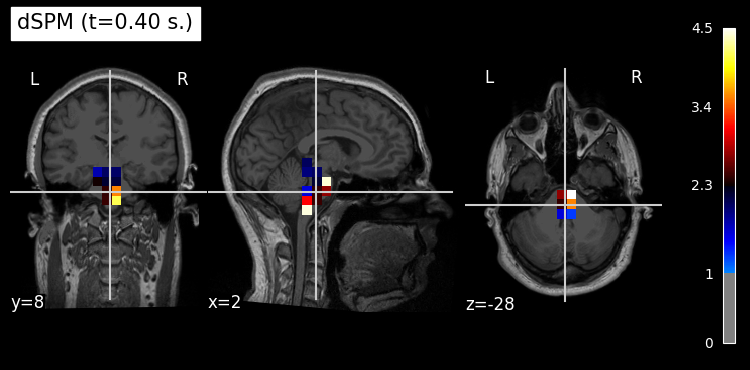

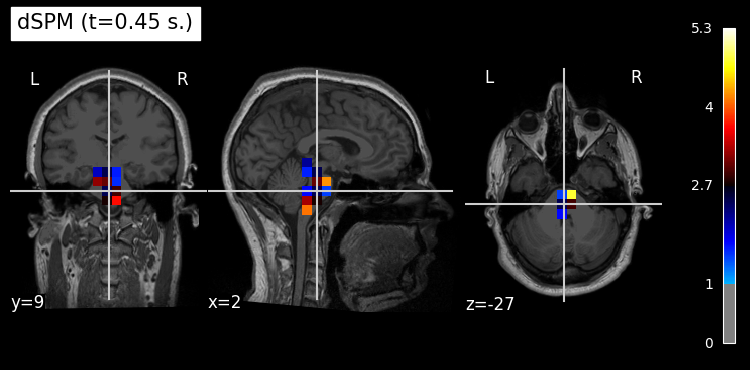

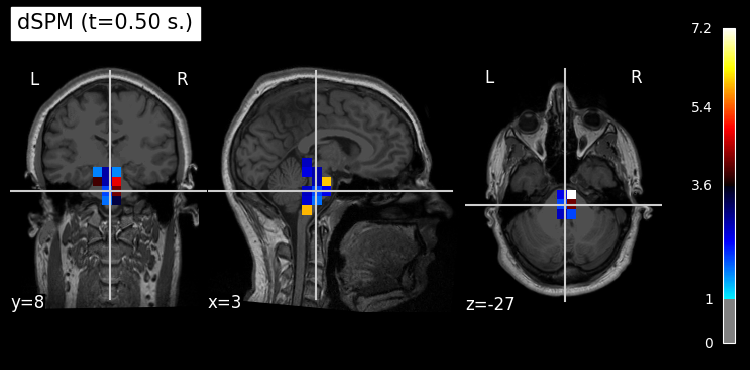

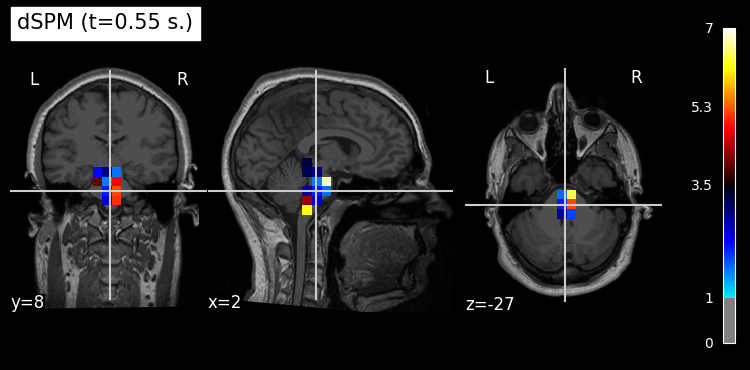

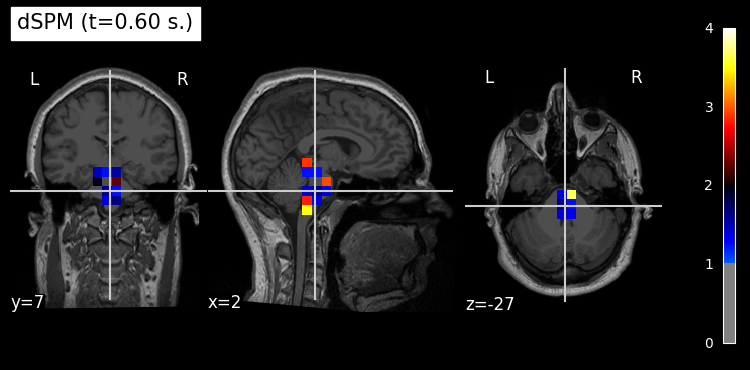

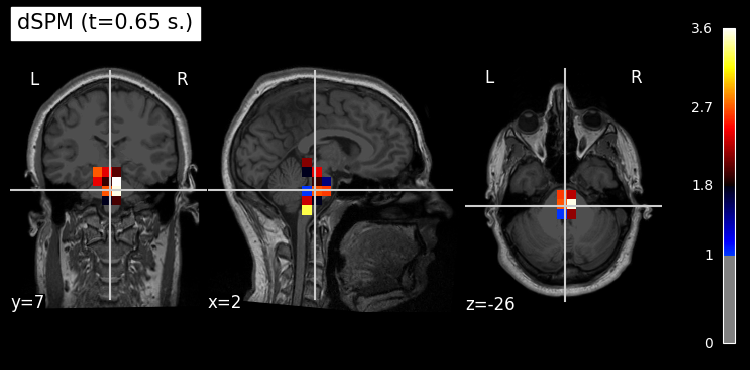

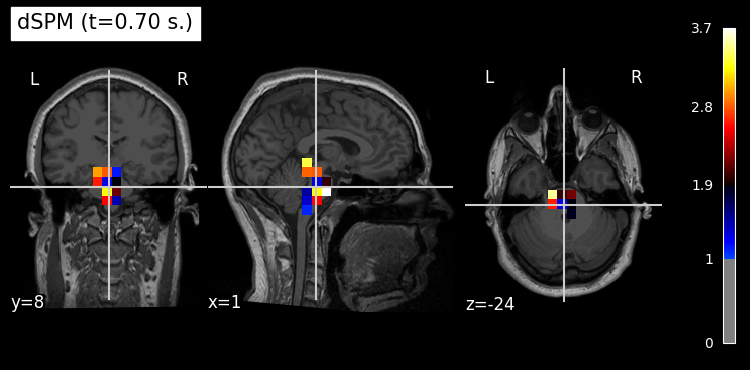

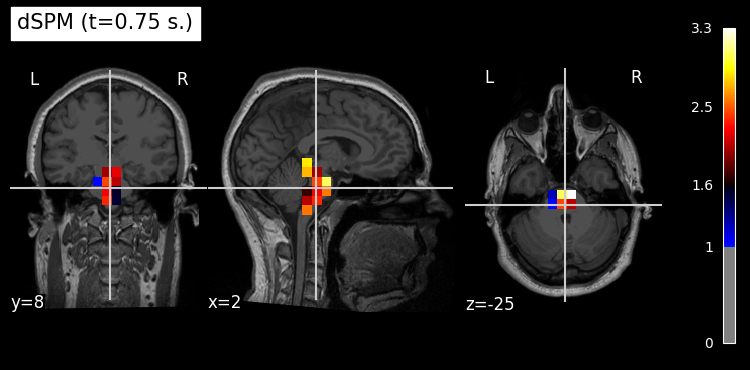

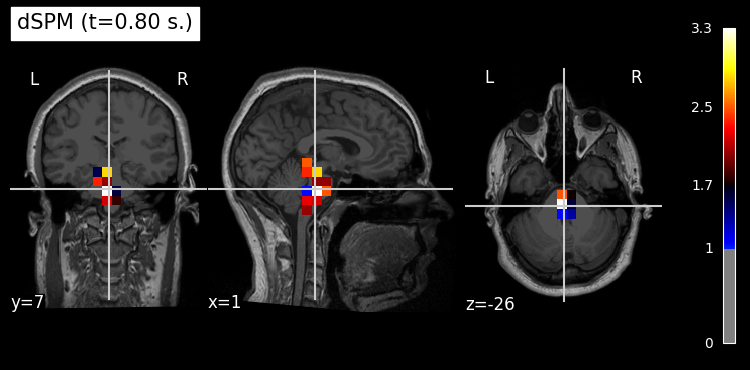

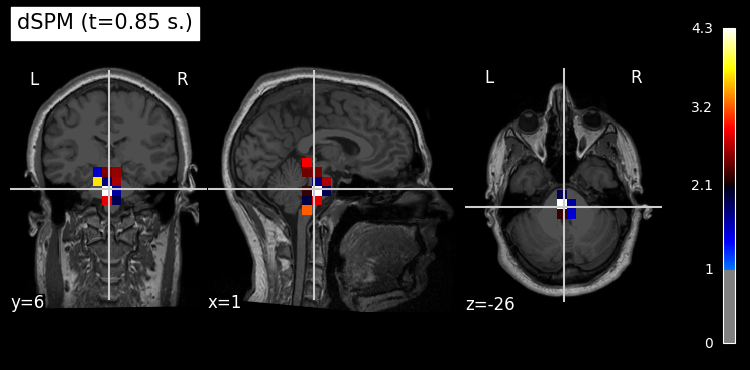

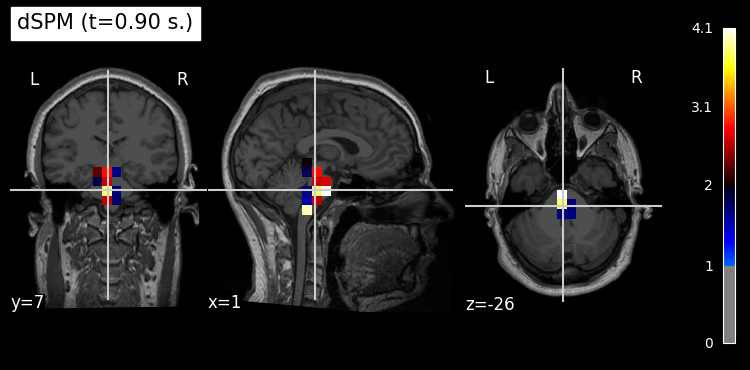

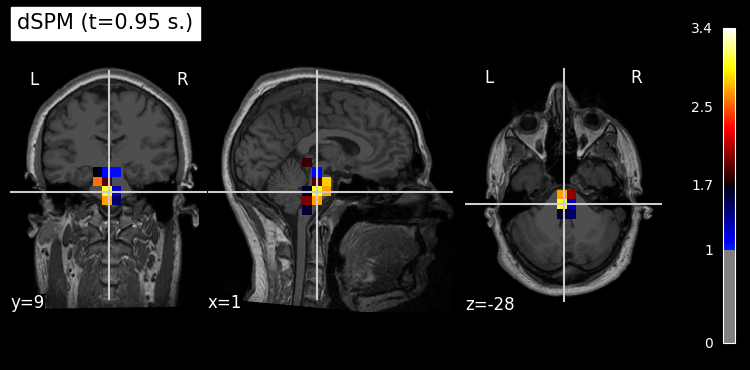

In [22]:
#Finally, we can make a plot on ucloud!

# Export result as a 4D nifti object
img = stc_vol.as_volume(src_vol, mri_resolution=False)  # set True for full MRI resolution

# Save it as a nifti file
# nib.save(img, 'mne_%s_inverse.nii.gz' % method)

t1_fname = join(mri_path, 'T1.mgz')

for i in range(len(z_t_h_50)):

    plot_stat_map(index_img(img, og_indices_list[i]), str(t1_fname), threshold=1.,
                  title='%s (t=%.2f s.)' % (method, z_t_h_50[i]))
    
    plt.show()

